<a href="https://colab.research.google.com/github/MerkulovDaniil/AALS-for-CP/blob/master/Notebooks/scalar_dynamics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install --upgrade --force-reinstall --quiet matplotlib 

     |████████████████████████████████| 4.3 MB 4.4 MB/s 
     |████████████████████████████████| 1.1 MB 48.6 MB/s 
     |████████████████████████████████| 98 kB 6.5 MB/s 
     |████████████████████████████████| 247 kB 61.9 MB/s 
     |████████████████████████████████| 40 kB 5.0 MB/s 
     |████████████████████████████████| 15.7 MB 45.8 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
google-colab 1.0.0 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
arviz 0.11.4 requires typing-extensions<4,>=3.7.4.3, but you have typing-extensions 4.1.1 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompa

# SDE

$$
\frac{dx(t)}{dt} = - \nabla f(x(t)) + \sqrt{2\sigma}* \mathcal{N}(0, 1)
$$

## Generating dynamics

In [3]:
# Hyperparameters
Function = 'FM sin'     # Minimums with different width, but the same values 
Function = 'Parabola'   # Just parabola
Function = 'Two peaks'  # Actuallu, this is two minimums, not peaks
Function = 'Super bad'  # A lot of local minimums and non-differentiable parts

methods = ["GF Euler", "HB Explicit", "NAG Explicit"]
 
N_solutions = 100       # Number of parallel solutions
sigma = 1e-1            # Noise level
t_start = 0             # Starting time value (should be zero)
t_end = 50              # Ending time value (may vary, depends from the f(x))
alpha = 1e-1            # Timestep
mu = 1.0                # Hyperparameter for accelerated schemes

In [ ]:
%matplotlib notebook
import jax.numpy as np
import numpy as onp
import math
from jax import grad, vmap
import jax
from tqdm import tqdm
from IPython.display import clear_output
clear_output()

from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

from matplotlib.pyplot import figure
import scipy.integrate as integrate

from scipy.stats import gaussian_kde
from scipy.stats import wasserstein_distance

def f_super_bad(x):
    return np.where((x - np.floor(x)) * np.abs(x + 5) < 0.2 * (np.abs(x) < 5), 
                    0.5 * np.floor(x),
           0.4 * np.exp(-2 * (x - 6)**2) + \
           2 * np.exp(-5 * (x + 4)**2) + \
           3 * np.exp(-0.5 * (x - 3)**4) + \
           0.5 * np.exp(- (x+7)**2) + \
           0.1 * np.cos(x * 30) + \
           0.01 * np.abs(x - 7) * np.sin(x**3 / 13) - \
           np.tanh(x**2) -
           0.1 * np.abs(x))
    
def f_fm_sin(x):
    c = 1.6 #@param {type:"slider", min:-5, max:5, step:0.1}
    t = 0.6 #@param {type:"slider", min:-1, max:1, step:0.05}
    return np.cos(c*x + 1/t*np.sin((1-t)*c*x) - math.pi) + 1

def f_parabola(x):
    return x**2

def f_two_peaks(x):
    a=2
    b=5
    return 1/50*(a*np.log(np.cosh(x))-b)**2

if Function == 'FM sin':
    f = f_fm_sin
    x_bounds=(-15,15)
    # draw_F(x_bounds=x_bounds, plot_df = True)
elif Function == 'Super bad':
    f = f_super_bad
    x_bounds=(-10,10)
    # draw_F(x_bounds=x_bounds, plot_df = True)
elif Function == 'Parabola':
    f = f_parabola
    x_bounds=(-2,2)
elif Function == "Two peaks":
    f = f_two_peaks
    x_bounds=(-10,10)


x_dynamics = dict()
v_dynamics = dict()
x_0 = dict()
kls = dict()
wds = dict()
t_seq = dict()
kde_pdfs = dict()

df = jax.jit(grad(f))

RNG = jax.random.PRNGKey(0)

for method in methods:
    RNG, subkey = jax.random.split(RNG)
    if method == "GF Euler":
        N_t_values = int((t_end - t_start)/alpha)
    elif method == "NAG Explicit":
        gamma_0 = np.sqrt(mu)
        N_t_values = int((t_end - t_start)/alpha)
    elif method == "HB Explicit":
        gamma_0 = np.sqrt(mu)
        N_t_values = int((t_end - t_start)/alpha)

    t_seq[method] = np.linspace(t_start, t_end, N_t_values)
    x_dynamics[method] = onp.zeros((N_solutions, N_t_values+1))
    v_dynamics[method] = onp.zeros((N_solutions, N_t_values+1))

    x_0 = jax.random.uniform(RNG, (N_solutions, 1), 
                         minval=x_bounds[0] + 0.2*np.abs(x_bounds[0]),
                         maxval=x_bounds[1]-0.2*np.abs(x_bounds[1]))
    
    kls[method] = [None for t in t_seq[method]]
    wds[method] = [None for t in t_seq[method]]
    
    x_dynamics[method][:, 0] = x_0.squeeze()

    for i_t, t_ in enumerate(tqdm(t_seq[method], desc=f"Calculating dynamics for {method}")):
        RNG, subkey = jax.random.split(RNG)
        W = jax.random.normal(RNG, (N_solutions, 1)).squeeze()

        if method == "GF Euler":
            grads = vmap(df)(x_dynamics[method][:, i_t])
            x_dynamics[method][:, i_t+1] = x_dynamics[method][:, i_t] - \
            alpha*grads + np.sqrt(2*sigma*alpha)*W
        elif method == "NAG Explicit":
            v_dynamics[method][:, 0] = x_0.squeeze()
            gamma = (gamma_0+mu*alpha)/(1+alpha)
            x_dynamics[method][:, i_t+1] = (x_dynamics[method][:, i_t] + alpha*v_dynamics[method][:, i_t])/(1 + alpha)
            grads = vmap(df)(x_dynamics[method][:, i_t+1])
            tau = (alpha*mu)/gamma
            v_dynamics[method][:, i_t+1] = (v_dynamics[method][:, i_t] + mu*alpha/gamma*x_dynamics[method][:, i_t+1] - alpha/gamma*grads + np.sqrt(2*sigma*alpha)*W)/(1+tau)
        elif method == "HB Explicit":
            gamma = (gamma_0+mu*alpha)/(1+alpha)
            x_dynamics[method][:, i_t+1] = x_dynamics[method][:, i_t] + alpha*v_dynamics[method][:, i_t]
            grads = vmap(df)(x_dynamics[method][:, i_t+1])
            v_dynamics[method][:, i_t+1] = 1.0/(1+2*alpha)*(-alpha/mu*grads + np.sqrt(2*sigma*alpha)*W + v_dynamics[method][:, i_t])

## Calculating KL and WD
We are given a function of stationary distribution and actual samples of dynamics at each timestep.

### KL
For calculating KL we will try to recover empirical density with KDE estimator (we have a problem with choosing bandwidth). After it we will just calculate an integral.

### WD
For calculating WD we will sample from stationary distribution and calculate WD between two 1D arrays.

In [5]:
%matplotlib inline
result = integrate.quad(lambda x: np.exp(-1/sigma*f(x)), x_bounds[0], x_bounds[1], limit=100)
z = result[0]

def fp_stationary(x, sigma = sigma, z=z):
    return 1/z*np.exp(-1/sigma*f(x))

# KL
kde = gaussian_kde(x_dynamics["GF Euler"][:, 0])
kde_pdf = kde.pdf

# this is not working :(
def kl_divergence_cont(p, q):
    result = integrate.quad(lambda x: p(x) * np.log(p(x)/q(x)), x_bounds[0], x_bounds[1], limit=100)
    return result[0]

def kl_divergence(p, q):
    return np.sum(np.where(p*q != 0, p * np.log(p / q), 0))

# WD
N_points = 1000
x_grid = np.linspace(*x_bounds, num=N_points)

def generate_cdf_values(x_grid, p):
    CDF_values = onp.zeros_like(x_grid)
    for i_x, x in enumerate(tqdm(x_grid[:-1], desc="Generating CDF")):
        CDF_values[i_x+1] = CDF_values[i_x] + integrate.quad(lambda t: p(t), x_grid[i_x], x_grid[i_x+1], limit=100)[0]
    
    return CDF_values

CDF_values = generate_cdf_values(x_grid, fp_stationary)

plt.plot(x_grid, CDF_values)
plt.title("FP stationary")
plt.ylabel("CDF")
plt.xlabel("x")
plt.show()

def fp_stationary_sample(N_samples, x_grid=x_grid, CDF_values=CDF_values, RNG=RNG):
    x_uniform_sample = jax.random.uniform(RNG, (N_samples,1), minval=0, maxval=1).squeeze()

    def find_nearest(value, array = CDF_values):
        return (np.abs(array - value)).argmin()

    idxs = vmap(find_nearest)(x_uniform_sample)

    return x_grid[idxs]

N_points = 1000
x = np.linspace(*x_bounds, N_points)

for method in methods:
    for i_t, t_ in enumerate(tqdm(t_seq[method], desc=f"Calculating metrics for {method}")):
        RNG, subkey = jax.random.split(RNG)

        x_list = x_dynamics[method][:, i_t]
        f_list = f(x_list)

        # WD ! TO IMPLEMENT MANUALLY
        x_fp_sample = fp_stationary_sample(N_solutions, RNG=RNG)
        wd = wasserstein_distance(x_list, x_fp_sample)
        wds[method][i_t] = wd

        # KL
        kde = gaussian_kde(x_dynamics[method][:, i_t], bw_method=0.05)
        kde_pdf = kde.pdf

        P_emp = kde_pdf(x)

        P_emp_ = P_emp/P_emp.sum()

        P_stat = fp_stationary(x)
        P_stat_ = P_stat/P_stat.sum()

        kl = kl_divergence(P_emp_, P_stat_)
        kls[method][i_t] = kl
    
    kde_pdfs[method] = kde_pdf

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: IntegrationWarning: The maximum number of subdivisions (100) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  
Generating CDF: 100%|██████████| 999/999 [00:22<00:00, 43.86it/s]


ImportError: ignored

<Figure size 432x288 with 1 Axes>

Calculating metrics for NAG Explicit: 100%|██████████| 500/500 [00:06<00:00, 74.26it/s]


## Simple graphs

In [6]:
# create a figure and axs["A"]es
fig = plt.figure(constrained_layout=True, figsize=(15,7))
axs  = fig.subplot_mosaic(
    """
    AC
    BD
    """
)

# set up the subplots as needed
plt.xlim(x_bounds)  

axs["A"].set_title("Function value")
axs["A"].set_xlabel('x')
axs["A"].set_ylabel('value')
axs["A"].plot(x, f(x), color = "red")

axs["B"].set_title("Solutions distribution at the last iteration.")
axs["B"].set_xlabel('x')
axs["B"].set_ylabel('value')
axs["B"].plot(x, fp_stationary(x), color = "red")

axs["C"].set_title(r"KL$(\rho(t), \rho^*)$")
axs["C"].set_xlabel("t")
axs["C"].set_xlim(t_seq["GF Euler"].min(), t_seq["GF Euler"].max())
axs["C"].grid(linestyle=':')

axs["D"].set_title(r"Wasserstein distance $(\rho(t), \rho^*)$")
axs["D"].set_xlabel("t")
axs["D"].set_xlim(t_seq["GF Euler"].min(), t_seq["GF Euler"].max())
axs["D"].grid(linestyle=':')

for method in methods:
    axs["A"].plot(x_dynamics[method][:, -1], f(x_dynamics[method][:, -1]), '.', ms=5)
    axs["B"].plot(x, kde_pdfs[method](x), label=method)
    axs["C"].plot(t_seq[method], kls[method])
    axs["D"].plot(t_seq[method], wds[method])

axs["B"].plot([None, None], color = "red", label=r"Stationary $p^*(x)$")
axs["B"].legend(loc='center right', bbox_to_anchor=(0.75, -0.35))
plt.show()

AttributeError: ignored

<Figure size 1080x504 with 0 Axes>

## Animated graphs

TypeError: ignored

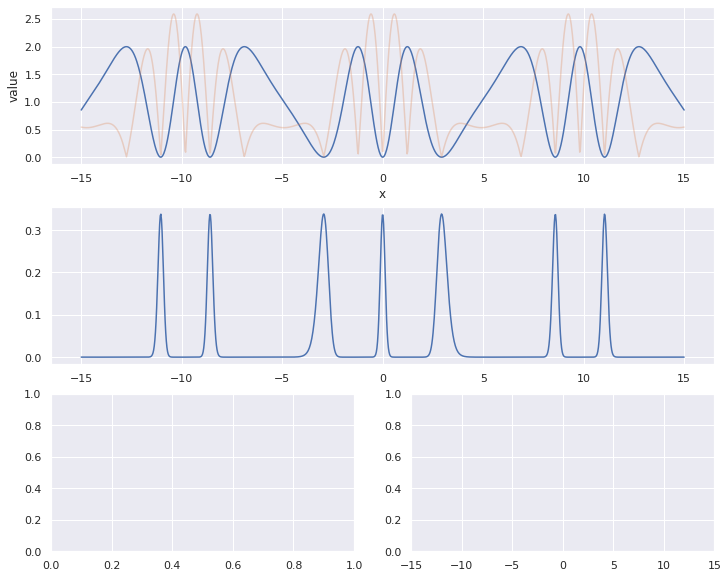

In [ ]:
import seaborn as sns
sns.set()
N_points = 1000
x = np.linspace(*x_bounds, N_points)

# Calculating normalization constant z


grads = vmap(df)(x)

# create a figure and axs["A"]es
fig = plt.figure(constrained_layout=True, figsize=(10,8))
axs  = fig.subplot_mosaic(
    """
    AA
    BB
    CD
    """
)

# fig, ax = plt.subplots(figsize=(14,5))

# set up the subplots as needed
plt.xlim(x_bounds)          
axs["A"].set_xlabel('x')
axs["A"].set_ylabel('value')

# create objects that will change in the animation. These are
# initially empty, and will be given new values for each frame
# in the animation.
txt_title = fig.suptitle('')
line_f, = axs["A"].plot(x, f(x), label="f(x)")     # ax["A"].plot returns a list of 2D line objects
line_grad, = axs["A"].plot(x, abs(grads), label=r"$|\nabla$ f(x)|", alpha=0.3)

line_fp, = axs["B"].plot(x, fp_stationary(x), label="FP stationary p(x)")     # axs["A"].plot returns a list of 2D line objects
kde = gaussian_kde(x_dynamics[:, 0], bw_method=0.05)
kde_pdf = kde.pdf
line_empirical_cdf, = axs["B"].plot(x, kde_pdf(x), label="Empirical density")   

line_kl, = axs["C"].plot(t_seq, [None for t in t_seq]) 
line_wd, = axs["D"].plot(t_seq, [None for t in t_seq])     
  

line_solutions, = axs["A"].plot([], [], 'r.', ms=20)
line_solutions_cdf, = axs["B"].plot([], [], 'r.', label='Solutions', ms=20)
tail_lines = []
for i in range(N_solutions):
    tail_lines.append(axs["A"].plot([], [], 'orange', lw=2)[0])
axs["A"].legend(loc='upper right')
axs["A"].grid(linestyle=':')
axs["B"].set_title("Solutions distribution")
axs["B"].legend(loc='upper right')
axs["B"].set_xlabel("x")
axs["B"].set_ylim(-1e-2, None)
axs["B"].grid(linestyle=':')
axs["C"].set_title(r"KL$(\rho(t), \rho^*)$")
axs["C"].set_xlabel("t")
axs["C"].set_xlim(t_seq.min(), t_seq.max())
axs["C"].set_ylim(0, 15)
axs["C"].grid(linestyle=':')
axs["D"].set_title(r"Wasserstein distance $(\rho(t), \rho^*)$")
axs["D"].set_xlabel("t")
axs["D"].set_xlim(t_seq.min(), t_seq.max())
axs["D"].set_ylim(0, 1.5)
axs["D"].grid(linestyle=':')

kls = [None for t in t_seq]
wds = [None for t in t_seq]

# animation function. This is called sequentially
def drawframe(n, sigma=sigma, kls=kls, z=z, RNG=RNG, wds=wds):
    tail_length = 30
    print(n)
    # for i in range(N_solutions):
    #     x_list = x_dynamics[i, max(0, n-tail_length):n]
    #     f_list = f(x_list)
    #     tail_lines[i].set_data(x_list, f_list)
    x_list = x_dynamics[:, n]
    f_list = f(x_list)
    line_solutions.set_data(x_list,f_list)
    line_solutions_cdf.set_data(x_list, np.zeros_like(x_list))


    # WD ! TO IMPLEMENT MANUALLY
    RNG, subkey = jax.random.split(RNG)
    x_fp_sample = fp_stationary_sample(N_solutions, RNG=RNG)
    wd = wasserstein_distance(x_list, x_fp_sample)
    wds[n] = wd
    line_wd.set_data(t_seq, wds)

    # KL
    kde = gaussian_kde(x_dynamics[:, n], bw_method=0.05)
    kde_pdf = kde.pdf

    P_emp = kde_pdf(x)
    line_empirical_cdf.set_data(x, P_emp)
    P_emp_ = P_emp/P_emp.sum()

    P_stat = fp_stationary(x)
    P_stat_ = P_stat/P_stat.sum()

    kl = kl_divergence(P_emp_, P_stat_)
    kls[n] = kl
    line_kl.set_data(t_seq, kls)

    txt_title.set_text(f"SGD SDE dynamics. {N_solutions} points with random uniform init; sigma = {sigma}")
    # kls.append(kl_divergence(fp_values, actual_values))
   
    return line_solutions, line_solutions_cdf

from matplotlib import animation

# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=N_t_values, interval=20, blit=True)
from IPython.display import HTML
html = HTML(anim.to_html5_video())
display(html)
plt.close()

# Legacy

In [ ]:
from matplotlib import animation
from IPython.display import HTML

def drawframe(n, x_dynamics_met=x_dynamics["NAG Explicit"]):
    print(n)
    dist.set_data(x_dynamics_met[:, n], onp.zeros_like(x_dynamics_met[:, n]))
    return dist, fig

fig = plt.figure(constrained_layout=True, figsize=(10,8))
axs  = fig.subplot_mosaic(
    """
    A
    """
)
dist, = axs["A"].plot([], [], 'r.', label='Solutions', ms=20)
axs["A"].set_xlim(-15,15)
anim = animation.FuncAnimation(fig, drawframe, frames=100, interval=20, blit=True)
html = HTML(anim.to_html5_video())
display(html)
plt.close()